# Model Version 2.0

### 1. Basic Feature Engineering

#### See ./R/basic_feature_engineering.R

In [7]:
from sklearn import model_selection
from model.run_lightGBM import get_model_dataset, run_lightGBM, make_submission,submission_blending
from util.feature_engineering import load_ads_data
import pandas as pd
import numpy as np
import gc
import lightgbm as lgb
from tqdm import tqdm
from sklearn import preprocessing
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
train_dat = pd.read_csv("../data/train_bsc_fe_txt_clean.csv", parse_dates=["activation_date"])  # (1503424, 18)
test_dat = pd.read_csv("../data/test_bsc_fe_txt_clean.csv", parse_dates=["activation_date"])  # (508438, 17)

In [3]:
train_dat.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability,is_desc,is_price,is_img,is_p1,is_p2,is_p3,price_log,itm_seq_log,mon,mday,week,wday,wend,title_len,desc_len,title_wc,desc_wc,title_punc,title_punc_suc,title_num,title_num_suc,title_upper,title_upper_suc,title_ascii,title_ascii_suc,title_space,title_punc_p,title_punc_suc_p,title_num_p,title_num_suc_p,title_upper_p,title_upper_suc_p,title_ascii_p,title_ascii_suc_p,title_space_p,desc_punc,desc_punc_suc,desc_num,desc_num_suc,desc_upper,desc_upper_suc,desc_ascii,desc_ascii_suc,desc_space,desc_punc_p,desc_punc_suc_p,desc_num_p,desc_num_suc_p,desc_upper_p,desc_upper_suc_p,desc_ascii_p,desc_ascii_suc_p,desc_space_p,title_stops,title_stops_p,desc_stops,desc_stops_p,title_nline,desc_nline,user_act_cnt,user_act_cnt_log,user_act_pcat_cnt,user_act_cat_cnt,pcat_pref,cat_pref,user_act_date,user_act_mon,user_act_mon_sd,user_act_mon_log,user_act_mon_ratio,user_act_mon_ratio_log,user_act_pcat_mon,user_act_mon_pcat_sd,user_act_mon_pcat_log,user_act_mon_pcat_ratio,user_act_mon_pcat_ratio_log,user_act_cat_mon,user_act_mon_cat_sd,user_act_mon_cat_log,user_act_mon_cat_ratio,user_act_mon_cat_ratio_log,cat_cnt,pcat_cnt,cat_price,cat_price_sd,cat_price_log,cat_price_ratio,pcat_price,pcat_price_sd,pcat_price_log,pcat_price_ratio,cat_img,cat_img_sd,cat_img_log,cat_img_ratio,pcat_img,pcat_img_sd,pcat_img_log,pcat_img_ratio,cat_seq,cat_seq_sd,cat_seq_log,cat_seq_ratio,pcat_seq,pcat_seq_sd,pcat_seq_log,pcat_seq_ratio,cat_date_cnt,pcat_date_cnt,cat_date_price,cat_date_price_sd,cat_date_price_log,cat_date_price_ratio,pcat_date_price,pcat_date_price_sd,pcat_date_price_log,pcat_date_price_ratio,cat_date_img,cat_date_img_sd,cat_date_img_log,cat_date_img_ratio,pcat_date_img,pcat_date_img_sd,pcat_date_img_log,pcat_date_img_ratio,cat_date_seq,cat_date_seq_sd,cat_date_seq_log,cat_date_seq_ratio,pcat_date_seq,pcat_date_seq_sd,pcat_date_seq_log,pcat_date_seq_ratio,reg_cnt,reg_price,reg_price_sd,reg_price_log,reg_price_ratio,reg_img,reg_img_sd,reg_img_log,reg_img_ratio,reg_seq,reg_seq_sd,reg_seq_log,reg_seq_ratio,reg_date_cnt,reg_date_price,reg_date_price_sd,reg_date_price_log,reg_date_price_ratio,reg_date_img,reg_date_img_sd,reg_date_img_log,reg_date_img_ratio,reg_date_seq,reg_date_seq_sd,reg_date_seq_log,reg_date_seq_ratio,p1_cnt,p1_price,p1_price_sd,p1_price_log,p1_price_ratio,p1_img,p1_img_sd,p1_img_log,p1_img_ratio,p1_seq,p1_seq_sd,p1_seq_log,p1_seq_ratio,p1_date_cnt,p1_date_price,p1_date_price_sd,p1_date_price_log,p1_date_price_ratio,p1_date_img,p1_date_img_sd,p1_date_img_log,p1_date_img_ratio,p1_date_seq,p1_date_seq_sd,p1_date_seq_log,p1_date_seq_ratio,p2_cnt,p2_price,p2_price_sd,p2_price_log,p2_price_ratio,p2_img,p2_img_sd,p2_img_log,p2_img_ratio,p2_seq,p2_seq_sd,p2_seq_log,p2_seq_ratio,p2_date_cnt,p2_date_price,p2_date_price_sd,p2_date_price_log,p2_date_price_ratio,p2_date_img,p2_date_img_sd,p2_date_img_log,p2_date_img_ratio,p2_date_seq,p2_date_seq_sd,p2_date_seq_log,p2_date_seq_ratio
0,b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,постельные принадлежности,NaN,NaN,кокоби кокон для сна,кокон для сна малыша пользовались меньше месяц...,400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789,1,1,1,1,0,0,5.993961,1.098612,3,28,13,вторник,0,21,58,2,2,2,0,0,0,0,0,4,0,2,0.095238,0.0,0.000000,0.000000,0.000000,0.0,0.190476,0.000000,0.095238,2,0,0,0,0,0,8,0,6,0.034483,0.0,0.000000,0.0,0.000000,0.000000,0.137931,0.000000,0.103448,1,0.5,1,0.5,0,0,1,0.693147,1,1,1.00,1.00,1,400.0,NaN,5.993961,1.000000,0.693147,400.0,NaN,5.993961,1.000000,0.693147,400.0,NaN,5.993961,1.0,0.693147,135280,914200,4007.415670,1.187752e+05,8.296151,0.099815,7446.711461,1.071076e+06,8.915662,0.053715,1064.794568,496.006900,6.971476,0.946661,485.337403,505.353775,6.186903,2.076906,185.017135,830.878080,5.225839,0.010810,192.

In [4]:
def text_mining_v1(dat, n_comp=3):
    print('NLP - tfidf')
    # Get Russian Stopwords
    stopWords = stopwords.words('russian')

    # Create tfidf matrix for title and description
    # tfidf = TfidfVectorizer(max_features=50000, stop_words=stopWords)

    tfidf = TfidfVectorizer(
        sublinear_tf=True,
        # strip_accents='unicode',
        analyzer='word',
        # token_pattern=r'\w{1,}',
        stop_words=stopWords,
        ngram_range=(1, 3),
        max_features=50000,
        norm='l2',
        min_df=3,
        max_df=0.6)

    tfidf_title = TfidfVectorizer(
        sublinear_tf=True,
        # strip_accents='unicode',
        analyzer='word',
        # token_pattern=r'\w{1,}',
        stop_words=stopWords,
        ngram_range=(1, 3),
        max_features=50000,
        norm='l2',
        min_df=3,
        max_df=0.6)

    dat['description'] = dat['description'].fillna(' ')
    dat['title'] = dat['title'].fillna(' ')
    tfidf.fit(dat['description'])
    tfidf_title.fit(dat['title'])

    dat_des_tfidf = tfidf.transform(dat['description'])
    dat_title_tfidf = tfidf.transform(dat['title'])

    # Get Key Components for tfidf matrix
    print('NLP - svd')
    svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_obj.fit(tfidf.transform(dat['description']))

    print(svd_obj.explained_variance_ratio_)

    svd_title = TruncatedSVD(n_components=n_comp, algorithm='arpack')
    svd_title.fit(tfidf.transform(dat['title']))

    print(svd_title.explained_variance_ratio_)

    dat_svd = pd.DataFrame(svd_obj.transform(dat_des_tfidf))
    dat_svd.columns = ['svd_des_' + str(i + 1) for i in range(n_comp)]
    # dat = pd.concat([dat, dat_svd], axis=1)
    dat = dat.join(dat_svd)

    dat_title_svd = pd.DataFrame(svd_title.transform(dat_title_tfidf))
    dat_title_svd.columns = ['svd_title_' + str(i + 1) for i in range(n_comp)]
    # dat = pd.concat([dat, dat_title_svd], axis=1)
    dat = dat.join(dat_title_svd)

    return dat


In [5]:
def feature_engineering_v1(train_dat, test_dat, noise=True, OHE=True):
    """
    # Deal Probability
    # dat['deal_class'] = dat['deal_probability'].apply(lambda x: ">=0.5" if x >= 0.5 else "<0.5")
    # interval = (-0.99, .10, .20, .30, .40, .50, .60, .70, .80, .90, 1.1)
    # cats = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
    # dat["deal_class_2"] = pd.cut(dat.deal_probability, interval, labels=cats)

    :param train_dat:
    :param test_dat:
    :return:
    """
    print('train data shape: ', train_dat.shape)
    print('test data shape: ', test_dat.shape)
    train_dat['tr_te'] = 1
    test_dat['tr_te'] = 0
    dat = pd.concat([train_dat, test_dat], axis=0)
    print('All data shape: ', dat.shape)  # (2011862, 37)

    # NLP
    dat = text_mining_v1(dat, 9)

    # Fill NA
    dat['price'].fillna(-1, inplace=True)

    # Target Mean
#     tgt_cols = ['deal_probability', 'price', 'image_top_1']
#     cate_cols = ['category_name', 'region', 'city', 'param_1', 'param_2', 'param_3',
#                  'parent_category_name', 'user_type', 'activation_date_dayofweek',
#                  'activation_date_weekend', ['activation_date_dayofweek', 'region']]
#     # 'user_id', ,'item_id'
#     measures = ['mean', 'std', 'quantile', 'skew', 'count']  # , 'kurt'
#     dat = dat.sort_values(by=['activation_date'])
#     dat = target_encoding(dat, tgt_cols, cate_cols, measures, noise)

    # Label Encoder
    # TODO(Ivan): Try to disable this part and test overfitting issue
    cat_vars = ["region", "city", "parent_category_name", "category_name", "user_type",
                "param_1", "param_2", "param_3"]
    ohe_vars = ["region", "parent_category_name", "category_name", "user_type", "wday"]
    if OHE:
        for col in tqdm(cat_vars):
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(dat[col].values.astype('str')))
            dat[col] = lbl.transform(list(dat[col].values.astype('str')))
        for c in tqdm(ohe_vars):
            ohe = pd.get_dummies(dat[c])
            ohe.columns = [c + str(col_name) for col_name in ohe.columns]
            dat = dat.drop(c, axis=1)
            dat = pd.concat([dat, ohe], axis=1)
    else:
        for col in tqdm(cat_vars):
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(dat[col].values.astype('str')))
            dat[col] = lbl.transform(list(dat[col].values.astype('str')))

    # Split train & test
    train_dat = dat[dat.tr_te == 1]
    test_dat = dat[dat.tr_te == 0]

    return train_dat, test_dat


In [8]:
train_df, test_df = feature_engineering_v1(train_dat, test_dat)
gc.collect()

train data shape:  (1503424, 230)
test data shape:  (508438, 230)
All data shape:  (2011862, 230)
NLP - tfidf


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\feature_extraction\text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


NLP - svd
[0.055133   0.00825951 0.00568336 0.00529263 0.00465856 0.00372814
 0.00323668 0.00300094 0.00299286]
[0.0508198  0.01662783 0.01580222 0.00924967 0.00864565 0.00809661
 0.00776976 0.0058344  0.00572411]


100%|█████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:40<00:00,  8.16s/it]


114

#### Aggregated Features

In [ ]:
gp = pd.read_csv('../data/aggregated_features.csv')
train_df = train_df.merge(gp, on='user_id', how='left')

In [9]:
train_df.head()

,item_id,user_id,city,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,image,image_top_1,deal_probability,is_desc,is_price,is_img,is_p1,is_p2,is_p3,price_log,itm_seq_log,mon,mday,week,wend,title_len,desc_len,title_wc,desc_wc,title_punc,title_punc_suc,title_num,title_num_suc,title_upper,title_upper_suc,title_ascii,title_ascii_suc,title_space,title_punc_p,title_punc_suc_p,title_num_p,title_num_suc_p,title_upper_p,title_upper_suc_p,title_ascii_p,title_ascii_suc_p,title_space_p,desc_punc,desc_punc_suc,desc_num,desc_num_suc,desc_upper,desc_upper_suc,desc_ascii,desc_ascii_suc,desc_space,desc_punc_p,desc_punc_suc_p,desc_num_p,desc_num_suc_p,desc_upper_p,desc_upper_suc_p,desc_ascii_p,desc_ascii_suc_p,desc_space_p,title_stops,title_stops_p,desc_stops,desc_stops_p,title_nline,desc_nline,user_act_cnt,user_act_cnt_log,user_act_pcat_cnt,user_act_cat_cnt,pcat_pref,cat_pref,user_act_date,user_act_mon,user_act_mon_sd,user_act_mon_log,user_act_mon_ratio,user_act_mon_ratio_log,user_act_pcat_mon,user_act_mon_pcat_sd,user_act_mon_pcat_log,user_act_mon_pcat_ratio,user_act_mon_pcat_ratio_log,user_act_cat_mon,user_act_mon_cat_sd,user_act_mon_cat_log,user_act_mon_cat_ratio,user_act_mon_cat_ratio_log,cat_cnt,pcat_cnt,cat_price,cat_price_sd,cat_price_log,cat_price_ratio,pcat_price,pcat_price_sd,pcat_price_log,pcat_price_ratio,cat_img,cat_img_sd,cat_img_log,cat_img_ratio,pcat_img,pcat_img_sd,pcat_img_log,pcat_img_ratio,cat_seq,cat_seq_sd,cat_seq_log,cat_seq_ratio,pcat_seq,pcat_seq_sd,pcat_seq_log,pcat_seq_ratio,cat_date_cnt,pcat_date_cnt,cat_date_price,cat_date_price_sd,cat_date_price_log,cat_date_price_ratio,pcat_date_price,pcat_date_price_sd,pcat_date_price_log,pcat_date_price_ratio,cat_date_img,cat_date_img_sd,cat_date_img_log,cat_date_img_ratio,pcat_date_img,pcat_date_img_sd,pcat_date_img_log,pcat_date_img_ratio,cat_date_seq,cat_date_seq_sd,cat_date_seq_log,cat_date_seq_ratio,pcat_date_seq,pcat_date_seq_sd,pcat_date_seq_log,pcat_date_seq_ratio,reg_cnt,reg_price,reg_price_sd,reg_price_log,reg_price_ratio,reg_img,reg_img_sd,reg_img_log,reg_img_ratio,reg_seq,reg_seq_sd,reg_seq_log,reg_seq_ratio,reg_date_cnt,reg_date_price,reg_date_price_sd,reg_date_price_log,reg_date_price_ratio,reg_date_img,reg_date_img_sd,reg_date_img_log,reg_date_img_ratio,reg_date_seq,reg_date_seq_sd,reg_date_seq_log,reg_date_seq_ratio,p1_cnt,p1_price,p1_price_sd,p1_price_log,p1_price_ratio,p1_img,p1_img_sd,p1_img_log,p1_img_ratio,p1_seq,p1_seq_sd,p1_seq_log,p1_seq_ratio,p1_date_cnt,p1_date_price,p1_date_price_sd,p1_date_price_log,p1_date_price_ratio,p1_date_img,p1_date_img_sd,p1_date_img_log,p1_date_img_ratio,p1_date_seq,p1_date_seq_sd,p1_date_seq_log,p1_date_seq_ratio,p2_cnt,p2_price,p2_price_sd,p2_price_log,p2_price_ratio,p2_img,p2_img_sd,p2_img_log,p2_img_ratio,p2_seq,p2_seq_sd,p2_seq_log,p2_seq_ratio,p2_date_cnt,p2_date_price,p2_date_price_sd,p2_date_price_log,p2_date_price_ratio,p2_date_img,p2_date_img_sd,p2_date_img_log,p2_date_img_ratio,p2_date_seq,p2_date_seq_sd,p2_date_seq_log,p2_date_seq_ratio,tr_te,svd_des_1,svd_des_2,svd_des_3,svd_des_4,svd_des_5,svd_des_6,svd_des_7,svd_des_8,svd_des_9,svd_title_1,svd_title_2,svd_title_3,svd_title_4,svd_title_5,svd_title_6,svd_title_7,svd_title_8,svd_title_9,region0,region1,region2,region3,region4,region5,region6,region7,region8,region9,region10,region11,region12,region13,region14,region15,region16,region17,region18,region19,region20,region21,region22,region23,region24,region25,region26,region27,parent_category_name0,parent_category_name1,parent_category_name2,parent_category_name3,parent_category_name4,parent_category_name5,parent_category_name6,parent_category_name7,parent_category_name8,category_name0,category_name1,category_name2,category_name3,category_name4,category_name5,category_name6,category_name7,category_name8,category_name9,category_name10,category_name11,category_name12,category_name13,category_name14,category_name15,category_name16,category_name17,category_name18,category_name19,category_na

In [10]:
features_to_drop = ['activation_date', 'deal_probability', 'description',
                        'image', 'item_id', 'title', 'tr_te', 'user_id']

In [11]:
train_X, train_y, val_X, val_y, test_X, test_id = get_model_dataset(train_df, test_df, features_to_drop,
                                                                        val_date='2017-03-27')
train_X, val_X, train_y, val_y = model_selection.train_test_split(pd.concat([train_X, val_X]),
                                                                  np.append(train_y, val_y),
                                                                  test_size=0.05, random_state=19)
gc.collect()
train_X.head()

train data shape:  (1275576, 329)
validation data shape:  (227848, 329)
test data shape:  (508438, 329)


In [17]:
### 4. run model
params = {
    "objective": "regression", #poisson, regression
    "metric": "rmse",
    "num_leaves": 32, #40
    'max_depth': 5, #15
    "learning_rate": 0.1, #0.09
    "bagging_fraction": 0.7,
    "feature_fraction": 0.7,
    "bagging_frequency": 5,
    "bagging_seed": 2018,
    "verbosity": -1
#     ,"boosting":"dart" # gbdt, rf, dart
    ,"device":"gpu"
}

In [28]:
def run_lightGBM_v2(train_X, train_y, val_X, val_y, test_X, params=None, early_stop=100, rounds=1000, cv = True):
    """

    :param train_X:
    :param train_y:
    :param val_X:
    :param val_y:
    :param test_X:
    :param params:
    :param early_stop:
    :param rounds:
    :return:
    """
    if params is None:
        params = {
            "objective": "regression",
            "metric": "rmse",
            "num_leaves": 30,
            "learning_rate": 0.1,
            "bagging_fraction": 0.7,
            "feature_fraction": 0.7,
            "bagging_frequency": 5,
            "bagging_seed": 2018,
            "verbosity": -1
        }

    lgtrain = lgb.Dataset(pd.concat([train_X, val_X]), label=np.append(train_y, val_y))
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}

    if cv:
        cv_results = lgb.cv(params, lgtrain, rounds, nfold=5, early_stopping_rounds=early_stop,
                            verbose_eval=100, stratified=False)
        rounds = cv_results['rmse-mean'].index(min(cv_results['rmse-mean']))

    model = lgb.train(params, lgtrain, rounds, valid_sets=[lgval], verbose_eval=100,
                      evals_result=evals_result)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)

    return pred_test_y, model, evals_result, cv_results

In [ ]:
pred_test_y, model, evals_result, cv_results = run_lightGBM_v2(train_X, train_y, val_X, val_y, test_X,
                                                            params=params, early_stop=100, rounds=5000)

[20]	cv_agg's rmse: 0.23503 + 0.000402686
[40]	cv_agg's rmse: 0.23186 + 0.00033316
[60]	cv_agg's rmse: 0.230346 + 0.000288853
[80]	cv_agg's rmse: 0.229471 + 0.000295066
[100]	cv_agg's rmse: 0.22884 + 0.000234751


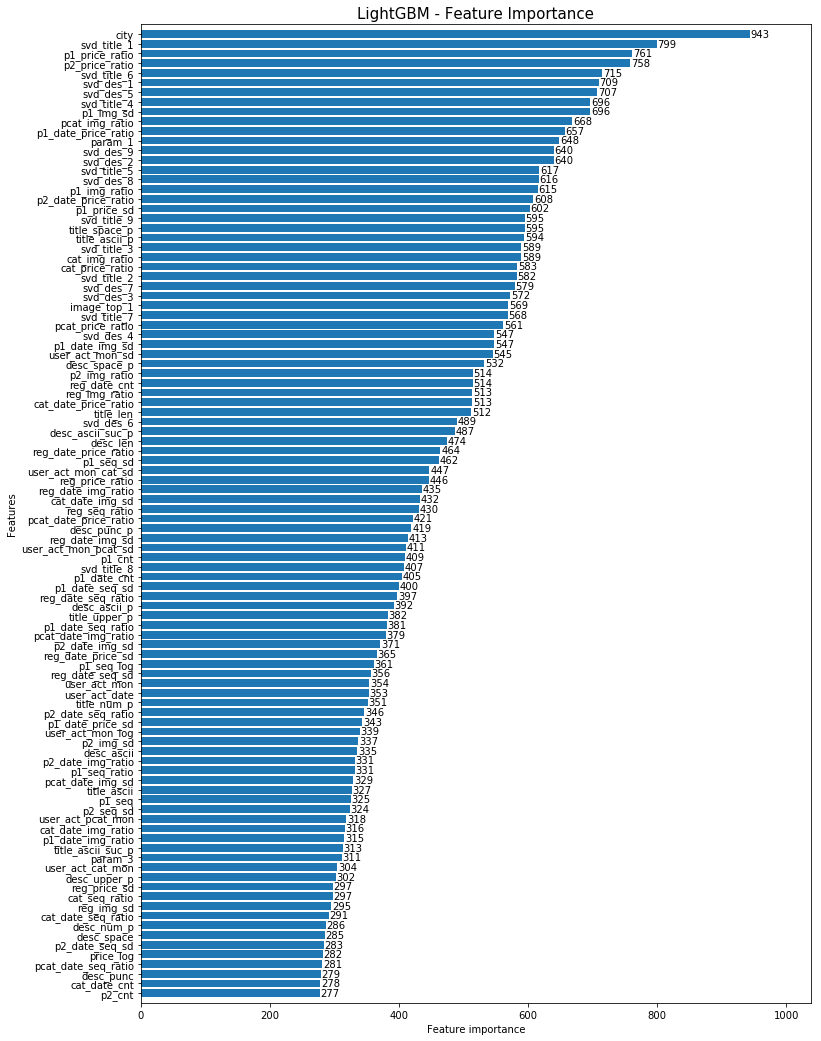

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 18))
lgb.plot_importance(model, max_num_features=100, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [16]:
### 5. make submission
res = make_submission(test_id, pred_test_y, filename='v2_0_1_rmse0_22238_sd0_000489537')


Predictions saved into: ../submissions/v2_0_1_poisson_rmse0_22238_sd0_000489537.csv


In [ ]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]